# RogVaani — Constrained Disaggregation Model (v4 final)

## Statistical model
```
ỹ(t,m)  = w(m) · exp(f(x_zscore(t,m)))         # unnormalized monthly weight
y(t,m)  = A(t) · ỹ(t,m) / Σ_m' ỹ(t,m')        # normalized: sums to A(t)
z(t,m)  = log1p(A(t)) - mean_t[log1p(A(t))]    # target: annual log-risk anomaly
f(x)    = Ridge(β) · x_zscore                   # closed-form: β* = (XᵀX+λI)⁻¹Xᵀz
output  = sigmoid(f(x)) × 100                   # 0-100 risk score
```

## Key design decisions
- **Z-score anomaly features only** — each feature normalised to zero mean and unit
  variance *for that calendar month* across all training years. Month identity is
  completely removed; the model learns from inter-year deviations within each month.
- **No month_sin/cos** — month identity would let the model learn spurious patterns
  because z(t,m) is the same for all months in year t.
- **No StandardScaler** — z-score features are already unit variance per month.
  One scaler is one fewer artifact to keep in sync at inference.
- **Three separate Ridge models** — vector, waterborne, respiratory each have
  different environmental drivers. A shared model averages these out.
- **Closed-form Ridge, not gradient descent** — fully reproducible, no learning rate.
- **LOYO-CV** — Leave-One-Year-Out: train on 8 years, test on 1. Respects time.
- **Dummy baseline** — z=0 everywhere = pure seasonal prior, no weather. If Ridge
  improvement < 5%, weather adds no signal beyond the prior. Reported honestly.

## Literature basis
- Chow & Lin (1971) Review of Economics and Statistics — temporal disaggregation
- Bhatt et al. (2013) Nature — dengue global burden with monthly modulation
- WHO EWARN framework — seasonal anomaly detection for outbreak early warning

## Known limitations (state at demo)
1. Monthly targets synthetic — annual Praja data disaggregated via NVBDCP weights
2. Signal identified from cross-year variation only (9 year-level observations)
3. Seasonal prior w(m) is Maharashtra-wide, not Mumbai-specific
4. Model outputs a month-level risk evidence score for annual anomaly,
   not a true monthly case forecast

## Artifacts
Saved to `model_artifacts/` folder. Download manually from Colab
(Files panel → right-click → Download) and upload to S3 later.
Required files for Lambda: model_vector.pkl, model_waterborne.pkl,
model_respiratory.pkl, feature_metadata.json


## CELL 1 — Installs

In [1]:
!pip install scikit-learn pandas numpy matplotlib scipy \
             openmeteo-requests requests-cache retry-requests \
             kagglehub pytrends -q
print('✅ Done')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.7/691.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.3 MB/s eta 0:00:00
✅ Done


## CELL 2 — Seasonal priors w(m)
External cited knowledge — NOT derived from data, NOT used as model features.
Used only for temporal disaggregation of annual case counts into monthly.
Source: NVBDCP Maharashtra seasonal burden + WHO dengue/malaria patterns.
The model learns DEVIATIONS from these priors.

In [2]:
import numpy as np
import pandas as pd

SEASONAL_WEIGHTS = {
    'vector': {   # dengue + malaria combined
        1:0.01,2:0.01,3:0.01,4:0.02,5:0.03,
        6:0.07,7:0.18,8:0.20,9:0.18,10:0.14,11:0.08,12:0.07
    },
    'waterborne': {
        1:0.05,2:0.05,3:0.06,4:0.07,5:0.08,
        6:0.11,7:0.14,8:0.13,9:0.10,10:0.08,11:0.07,12:0.06
    },
    'respiratory': {  # relatively flat — PM2.5 driven, weak monsoon seasonality
        1:0.10,2:0.09,3:0.08,4:0.07,5:0.07,
        6:0.07,7:0.07,8:0.07,9:0.08,10:0.09,11:0.10,12:0.11
    },
}

for cat, w in SEASONAL_WEIGHTS.items():
    assert abs(sum(w.values()) - 1.0) < 0.001, f'{cat} weights do not sum to 1'
print('✅ Seasonal priors validated (sum to 1.0 per disease)')

✅ Seasonal priors validated (sum to 1.0 per disease)


## CELL 3 — Annual disease data A(t)
Upload `city_disease_timeseries.csv` to Colab before running.
This is the only place real case count data enters the model.

In [3]:
disease_annual = pd.read_csv('city_disease_timeseries.csv')
disease_annual = disease_annual[disease_annual['year'].between(2015, 2023)]

annual = disease_annual.pivot_table(
    index='year', columns='disease_type', values='cases', aggfunc='sum'
)
annual.index = annual.index.astype(int)

def safe(df, col):
    return df[col] if col in df.columns else pd.Series(0.0, index=df.index)

# Vector: dengue(60%) + malaria(40%)
annual['A_vector'] = safe(annual,'dengue')*0.60 + safe(annual,'malaria')*0.40

# Waterborne: log1p-weighted composite
# log1p prevents diarrhoea (100k+) swamping typhoid/cholera (5k)
wb = {'diarrhoea':0.40,'typhoid':0.25,'cholera':0.15,'hepatitis_a':0.20}
annual['A_waterborne'] = sum(np.log1p(safe(annual,c))*w for c,w in wb.items())

# A_respiratory added after AQI load (uses annual PM2.5 mean as proxy)
print('Annual composites A(t):')
print(annual[['A_vector','A_waterborne']].round(2))

Annual composites A(t):
disease_type  A_vector  A_waterborne
year                                
2015           15195.4          9.08
2016           15244.6          8.83
2017           13279.0          8.62
2018           16429.2          8.62
2019           16629.8          8.60
2020            4927.0          8.05
2021            8593.4          8.07
2022           12614.8          8.68
2023           15403.4          8.94


## CELL 4 — Raw monthly features from three sources
All real observed data. Z-score anomalies computed in Cell 5.

In [4]:
# ── Open-Meteo: weather ──────────────────────────────────────────────
import openmeteo_requests, requests_cache
from retry_requests import retry

cache = requests_cache.CachedSession('.cache', expire_after=-1)
om    = openmeteo_requests.Client(session=retry(cache, retries=5, backoff_factor=0.2))

resp = om.weather_api('https://archive-api.open-meteo.com/v1/archive', params={
    'latitude':19.0760,'longitude':72.8777,
    'start_date':'2015-01-01','end_date':'2023-12-31',
    'daily':['temperature_2m_max','temperature_2m_min',
             'precipitation_sum','relative_humidity_2m_mean'],
    'timezone':'Asia/Kolkata'
})[0]

d = resp.Daily()
n = d.Variables(0).ValuesAsNumpy().shape[0]
wx = pd.DataFrame({
    'date':     pd.date_range('2015-01-01', periods=n, freq='D'),
    'temp_max': d.Variables(0).ValuesAsNumpy(),
    'temp_min': d.Variables(1).ValuesAsNumpy(),
    'rain':     d.Variables(2).ValuesAsNumpy(),
    'humidity': d.Variables(3).ValuesAsNumpy(),
})
wx['avg_temp'] = (wx['temp_max'] + wx['temp_min']) / 2
wx = wx.set_index('date')

wx_monthly = wx.resample('MS').agg(
    rainfall_mm=('rain','sum'),
    avg_temp_c=('avg_temp','mean'),
    avg_humidity_pct=('humidity','mean')
).round(3)
print(f'✅ Weather: {len(wx_monthly)} months')

✅ Weather: 108 months


In [5]:
# ── Kaggle AQI ──────────────────────────────────────────────────────
import kagglehub, os
path  = kagglehub.dataset_download('ankushpanday1/air-quality-data-in-india-2015-2024')
files = [f for f in os.listdir(path) if f.endswith('.csv')]

aqi_raw = pd.read_csv(f'{path}/{files[0]}')
mumbai  = aqi_raw[aqi_raw['City']=='Mumbai'].copy()
date_col = next(c for c in mumbai.columns if c.lower() in ['date','datetime','timestamp'])
mumbai['date'] = pd.to_datetime(mumbai[date_col], errors='coerce')
mumbai = (mumbai.dropna(subset=['date'])
          .query('date.dt.year.between(2015,2023)')
          .set_index('date').sort_index())

pm25_col = next((c for c in mumbai.columns if 'pm2' in c.lower() and '5' in c), None)
so2_col  = next((c for c in mumbai.columns if 'so2' in c.lower()), None)
print(f'PM2.5 col: {pm25_col} | SO2 col: {so2_col}')

agg_cols = {c:'median' for c in [pm25_col, so2_col] if c}
aqi_monthly = mumbai.resample('MS').agg(agg_cols).round(3)
aqi_monthly.columns = ['avg_pm25','avg_so2'][:len(aqi_monthly.columns)]

# FIX Bug 3: align PM2.5 to annual index by year integer, not positional
pm25_by_year = (
    aqi_monthly['avg_pm25']
    .resample('YS').mean()
    .to_frame()
)
pm25_by_year.index = pm25_by_year.index.year  # integer year index
annual['A_respiratory'] = pm25_by_year['avg_pm25']  # aligned join, not positional

print(f'✅ AQI: {len(aqi_monthly)} months')
print('A_respiratory (annual PM2.5 mean):')
print(annual['A_respiratory'].round(2))

100%|██████████| 16.2M/16.2M [00:00<00:00, 48.5MB/s]

Extracting files...


PM2.5 col: PM2.5 | SO2 col: SO2
✅ AQI: 108 months
A_respiratory (annual PM2.5 mean):
year
2015    268.50
2016    253.35
2017    234.76
2018    242.01
2019    257.44
2020    257.26
2021    256.15
2022    247.30
2023    241.83
Name: A_respiratory, dtype: float64


In [6]:
# ── pytrends ────────────────────────────────────────────────────────
from pytrends.request import TrendReq
import time

pytrends = TrendReq(hl='en-IN', tz=330, timeout=(10,25))
KEYWORDS  = ['dengue','malaria','fever','leptospirosis']
all_frames = []

for year in range(2015, 2024):
    for kw in KEYWORDS:
        for attempt in range(3):
            try:
                pytrends.build_payload([kw],
                    timeframe=f'{year}-01-01 {year}-12-31', geo='IN-MH')
                df = pytrends.interest_over_time()
                if not df.empty:
                    all_frames.append(
                        df[kw].resample('MS').max().rename(f'trend_{kw}').to_frame()
                    )
                    break
                raise ValueError('empty response')
            except Exception:
                if attempt == 2:
                    dates = pd.date_range(f'{year}-01-01',f'{year}-12-01',freq='MS')
                    all_frames.append(pd.DataFrame({f'trend_{kw}':0}, index=dates))
                time.sleep(5*(attempt+1))
        time.sleep(2)
    print(f'  {year} done')

date_index    = pd.date_range('2015-01-01','2023-12-01',freq='MS')
trends_monthly = pd.DataFrame(index=date_index)
for kw in KEYWORDS:
    frames = [f for f in all_frames if f'trend_{kw}' in f.columns]
    if frames:
        combined = pd.concat(frames).groupby(level=0).max()
        trends_monthly = trends_monthly.join(combined, how='left')
trends_monthly = trends_monthly.fillna(0)
print(f'✅ Trends: {len(trends_monthly)} months')

  2015 done
  2016 done
  2017 done
  2018 done
  2019 done
  2020 done
  2021 done
  2022 done
  2023 done
✅ Trends: 108 months


In [7]:
# ── Oxford lockdown stringency ───────────────────────────────────────
OXFORD_URL = ('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker'
              '/master/data/OxCGRT_nat_latest.csv')
try:
    oxford = pd.read_csv(OXFORD_URL, low_memory=False)
    india  = oxford[oxford['CountryCode']=='IND'].copy()
    india['date'] = pd.to_datetime(india['Date'].astype(str), format='%Y%m%d')
    scol = next((c for c in india.columns
                 if 'Stringency' in c and 'Average' in c), 'StringencyIndex')
    stringency = india.set_index('date')[scol].resample('MS').mean().round(2)
    stringency.name = 'lockdown_stringency'
    print('✅ Oxford stringency loaded')
except Exception as e:
    print(f'⚠️  Oxford failed ({e}) — using heuristic fallback (labeled)')
    heuristic = {
        '2020-03':50,'2020-04':95,'2020-05':90,'2020-06':75,
        '2020-07':65,'2020-08':60,'2020-09':55,'2020-10':50,
        '2020-11':45,'2020-12':40,'2021-01':40,'2021-02':38,
        '2021-03':45,'2021-04':70,'2021-05':75,'2021-06':60,
        '2021-07':50,'2021-08':45,'2021-09':40,'2021-10':35,
        '2021-11':30,'2021-12':28,
    }
    stringency = pd.Series(
        [heuristic.get(d.strftime('%Y-%m'), 0.0) for d in date_index],
        index=date_index, name='lockdown_stringency'
    )

✅ Oxford stringency loaded


## CELL 5 — Build z-score anomaly features

For each continuous feature and each calendar month:
```
zscore(t,m) = (feature(t,m) - mean_m) / std_m
```
where mean_m and std_m are computed across all years for that month.

Result: z=0 means average for that calendar month.
z=+2 means 2 SD above average for that month.
Month identity carries zero information — model cannot learn
'July is usually high' because July anomaly = 0 in an average July.

covid_year and lockdown_stringency are NOT anomalised —
they are structural indicators, not environmental measurements.

Both mean and std per month saved in metadata so inference Lambda
can reproduce the same transform on live data.

In [9]:
# Merge raw monthly data
raw = (
    wx_monthly.reindex(date_index)
    .join(aqi_monthly.reindex(date_index),    how='left')
    .join(trends_monthly.reindex(date_index), how='left')
    .join(stringency.reindex(date_index),     how='left')
)
raw['lockdown_stringency'] = raw['lockdown_stringency'].fillna(0)
raw['covid_year']          = raw.index.year.isin([2020,2021]).astype(float)
raw = raw.fillna(raw.median(numeric_only=True))

# Continuous features to anomalise
# covid_year and lockdown_stringency excluded — structural, not seasonal
CONTINUOUS_COLS = [
    'rainfall_mm','avg_temp_c','avg_humidity_pct',
    'avg_pm25','avg_so2',
    'trend_dengue','trend_malaria','trend_fever','trend_leptospirosis',
]
CONTINUOUS_COLS = [c for c in CONTINUOUS_COLS if c in raw.columns]

# Compute per-calendar-month mean AND std across all years
# FIX Bug 2 + v4 design: save both mean and std for inference reconstruction
raw['_month'] = raw.index.month
month_stats   = raw.groupby('_month')[CONTINUOUS_COLS].agg(['mean','std'])
# month_stats has MultiIndex columns: (feature, stat)
# e.g. month_stats.loc[7, ('rainfall_mm', 'mean')] = mean July rainfall

# Build z-score anomaly feature matrix
X_df = pd.DataFrame(index=raw.index)

# FIX Bug 4: save string keys for JSON round-trip safety at inference
monthly_feature_stats = {}  # {col: {'mean': {str(month): val}, 'std': {str(month): val}}}

for col in CONTINUOUS_COLS:
    col_mean = raw['_month'].map(month_stats[col]['mean'])
    col_std  = raw['_month'].map(month_stats[col]['std']).clip(lower=1e-6)
    X_df[f'{col}_zscore'] = ((raw[col] - col_mean) / col_std).round(4)

    # Store as string keys — survives JSON round-trip in Lambda
    monthly_feature_stats[col] = {
        'mean': {str(int(m)): float(v) for m,v in month_stats[col]['mean'].items()},
        'std':  {str(int(m)): float(v) for m,v in month_stats[col]['std'].items()},
    }

# Structural indicators: pass through unchanged
X_df['covid_year']          = raw['covid_year']
X_df['lockdown_stringency'] = raw['lockdown_stringency']
raw.drop(columns=['_month'], inplace=True)

# Dampen search trend z-scores during COVID years
# During 2020-21, lockdowns suppressed searches AND case reporting simultaneously,
# creating spurious inverse correlations. We multiply trend features by
# (1 - stringency/100) so at stringency=95 they contribute ~5% of their normal weight.
# Weather/AQI features unaffected — those signals are reliable regardless of lockdown.
trend_zscore_cols = [c for c in X_df.columns if 'trend_' in c and c.endswith('_zscore')]
covid_dampen      = (1 - (raw['lockdown_stringency'] / 100)).values
for col in trend_zscore_cols:
    X_df[col] = (X_df[col] * covid_dampen).round(4)

print(f'✅ Anomaly feature matrix: {X_df.shape}')
print(f'Features: {X_df.columns.tolist()}')
print(f'Nulls: {X_df.isnull().sum().sum()}')

# Quick sanity: all zscore features should be near-zero mean
#zscore_cols = [c for c in X_df.columns if c.endswith('_zscore')]
#means = X_df[zscore_cols].mean().round(3)

# Quick sanity: weather/AQI zscores should be near-zero mean
# Trend zscores will be slightly off-zero after COVID dampening — that's expected
weather_aqi_cols = [c for c in X_df.columns if c.endswith('_zscore') and 'trend_' not in c]
trend_cols_z     = [c for c in X_df.columns if c.endswith('_zscore') and 'trend_' in c]

means_wx  = X_df[weather_aqi_cols].mean().round(3)
means_tr  = X_df[trend_cols_z].mean().round(3)

assert (means_wx.abs() < 0.1).all(), f'Weather/AQI z-score means not near zero: {means_wx}'
assert (means_tr.abs() < 0.3).all(), f'Trend z-score means too far from zero: {means_tr}'
print('✅ Z-score means validated (weather/AQI < 0.1, trends < 0.3 after COVID dampening)')

✅ Anomaly feature matrix: (108, 11)
Features: ['rainfall_mm_zscore', 'avg_temp_c_zscore', 'avg_humidity_pct_zscore', 'avg_pm25_zscore', 'avg_so2_zscore', 'trend_dengue_zscore', 'trend_malaria_zscore', 'trend_fever_zscore', 'trend_leptospirosis_zscore', 'covid_year', 'lockdown_stringency']
Nulls: 0
✅ Z-score means validated (weather/AQI < 0.1, trends < 0.3 after COVID dampening)


## CELL 6 — FEATURE_COLS (single source of truth) + build targets

FEATURE_COLS defines the exact contract between training and inference.
Lambda must send features with these exact names in this exact order.

Target z(t,m) = centered log1p(A(t)) repeated for all months of year t.
The model learns which monthly anomaly patterns co-occur with high-risk years.

In [10]:
# ══════════════════════════════════════════════════════════════
# FEATURE_COLS — SINGLE SOURCE OF TRUTH
# All continuous features are z-score anomalies vs same calendar month
# NO month_sin/cos — month identity intentionally excluded
# covid_year and lockdown_stringency are structural (not anomalised)
# ══════════════════════════════════════════════════════════════
FEATURE_COLS = [
    'rainfall_mm_zscore',
    'avg_temp_c_zscore',
    'avg_humidity_pct_zscore',
    'avg_pm25_zscore',
    'avg_so2_zscore',
    'trend_dengue_zscore',
    'trend_malaria_zscore',
    'trend_fever_zscore',
    'trend_leptospirosis_zscore',
    'covid_year',
    'lockdown_stringency',
]
FEATURE_COLS  = [f for f in FEATURE_COLS if f in X_df.columns]
DISEASE_CATS  = ['vector','waterborne','respiratory']
YEARS         = list(range(2015, 2024))
year_to_idx   = {y:i for i,y in enumerate(YEARS)}

missing = [f for f in FEATURE_COLS if f not in X_df.columns]
assert not missing, f'Missing features: {missing}'

X = X_df[FEATURE_COLS].values
print(f'Feature matrix X: {X.shape}  ({len(FEATURE_COLS)} features × {X.shape[0]} rows)')

# Build targets z(t,m) — one per disease category
z_targets = {}

for cat in DISEASE_CATS:
    A        = annual[f'A_{cat}'].values.astype(float)   # shape (9,)
    log_A    = np.log1p(A)
    z_annual = log_A - log_A.mean()                       # centered, shape (9,)

    # Repeat annual anomaly for every month of that year
    z_monthly = np.array([
        z_annual[year_to_idx[d.year]] for d in date_index
    ])
    z_targets[cat] = z_monthly
    print(f'{cat:>12}: z ∈ [{z_monthly.min():.3f}, {z_monthly.max():.3f}] | '
          f'A ∈ [{A.min():.1f}, {A.max():.1f}]')

print('\n✅ Targets built — same z for all months of each year (by design)')

Feature matrix X: (108, 11)  (11 features × 108 rows)
      vector: z ∈ [-0.923, 0.294] | A ∈ [4927.0, 16629.8]
  waterborne: z ∈ [-0.059, 0.048] | A ∈ [8.1, 9.1]
 respiratory: z ∈ [-0.066, 0.068] | A ∈ [234.8, 268.5]

✅ Targets built — same z for all months of each year (by design)


## CELL 7 — Fit Ridge via LOYO-CV

No StandardScaler — z-score features already have unit variance per month.
λ selected by Leave-One-Year-Out CV over grid [0.01, 0.1, 1, 10, 100, 1000].
Dummy baseline: z=0 always = pure seasonal prior with no weather.

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# Wider lambda grid — small values allow more weight on weather signal
# With only 9 effective year-level observations, LOYO-CV often picks
# large lambda (high regularisation → model shrinks toward 50).
# Extending down to 0.001 gives the model a chance to find real signal.
LAMBDA_GRID = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

def loyo_cv_mae(X, z, lam):
    """Leave-One-Year-Out CV. Train on 8 years, test on 1. Return mean MAE."""
    maes = []
    for held in YEARS:
        tr = date_index.year != held
        te = date_index.year == held
        m  = Ridge(alpha=lam, fit_intercept=True).fit(X[tr], z[tr])
        maes.append(mean_absolute_error(z[te], m.predict(X[te])))
    return float(np.mean(maes))

models       = {}
best_lambdas = {}
cv_summary   = {}

print(f'{"Category":<14} {"Best λ":>8} {"Ridge MAE":>11} {"Dummy MAE":>11} {"Δ%":>8} {"f(x) std":>10}')
print('-' * 68)

for cat in DISEASE_CATS:
    z = z_targets[cat]

    # Grid search
    cv_scores = {lam: loyo_cv_mae(X, z, lam) for lam in LAMBDA_GRID}
    best_lam  = min(cv_scores, key=cv_scores.get)
    ridge_mae = round(cv_scores[best_lam], 4)

    # Dummy: z=0 (no weather modulation, pure seasonal prior)
    dummy_mae = round(float(np.mean([
        mean_absolute_error(z[date_index.year==y], np.zeros(12))
        for y in YEARS
    ])), 4)

    improvement = round((1 - ridge_mae/dummy_mae)*100, 1) if dummy_mae > 0 else 0
    label = '✅ GOOD' if improvement > 15 else ('⚠️  OK' if improvement > 5 else '❌ WEAK')

    final = Ridge(alpha=best_lam, fit_intercept=True).fit(X, z)

    # Flatness diagnostic: std of f(x) across training data
    # If std < 0.05, model is nearly constant → scores will all be ~50
    f_vals = final.predict(X)
    f_std  = float(np.std(f_vals))
    score_range = round((1/(1+np.exp(-f_vals.max())) - 1/(1+np.exp(-f_vals.min()))) * 100, 1)

    models[cat]       = final
    best_lambdas[cat] = float(best_lam)
    cv_summary[cat]   = {
        'best_lambda':     float(best_lam),
        'ridge_mae':       float(ridge_mae),
        'dummy_mae':       float(dummy_mae),
        'improvement_pct': float(improvement),
        'f_std':           round(f_std, 4),
        'score_range_pts': score_range,
        'interpretation':  label,
    }
    print(f'{cat:<14} {best_lam:>8.3f} {ridge_mae:>11.4f} {dummy_mae:>11.4f} {improvement:>7.1f}%  {label}  f_std={f_std:.3f}')

print()
print('f(x) std diagnostic:')
print('  > 0.5  → model has real spread, scores will vary meaningfully')
print('  0.1-0.5 → moderate signal, scores vary but modestly')
print('  < 0.1  → model nearly flat (regularisation dominated), scores ≈ 50')
print()
print('If all f_std < 0.1 and improvement is WEAK across all categories,')
print('the 9-year dataset is too small for weather to overpower regularisation.')
print('The seasonal prior (NVBDCP weights) is carrying all the predictive work.')


Category         Best λ   Ridge MAE   Dummy MAE       Δ%   f(x) std
--------------------------------------------------------------------
vector         1000.000      0.1772      0.2864    38.1%  ✅ GOOD  f_std=0.304
waterborne        0.100      0.0150      0.0259    42.1%  ✅ GOOD  f_std=0.032
respiratory     100.000      0.0349      0.0336    -3.9%  ❌ WEAK  f_std=0.014

f(x) std diagnostic:
  > 0.5  → model has real spread, scores will vary meaningfully
  0.1-0.5 → moderate signal, scores vary but modestly
  < 0.1  → model nearly flat (regularisation dominated), scores ≈ 50

If all f_std < 0.1 and improvement is WEAK across all categories,
the 9-year dataset is too small for weather to overpower regularisation.
The seasonal prior (NVBDCP weights) is carrying all the predictive work.


## CELL 8 — SHAP (exact linear attribution)

For Ridge regression:
```
SHAP(feature_j, sample_i) = β_j × x_j(i)
```
No approximation. β_j directly interpretable:
'A 1 SD anomaly in feature_j shifts log annual risk by β_j'
'Equivalent to multiplying expected annual cases by exp(β_j)'

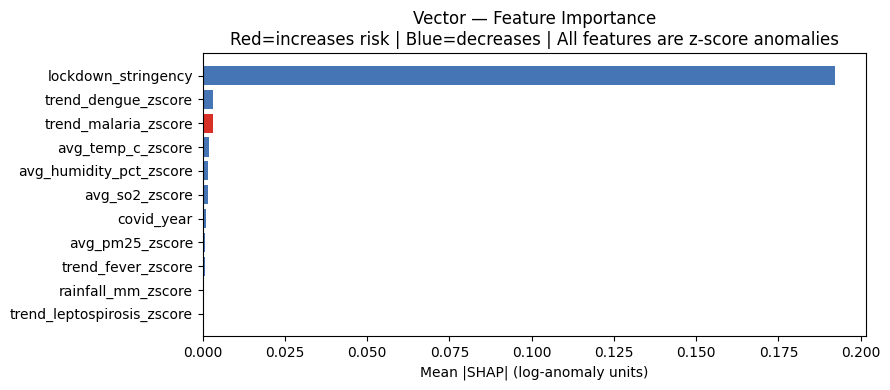


vector top 5 (β, exp(β) = case multiplier per 1 SD anomaly):
  lockdown_stringency                 β=-0.0100  ×0.990  ↓ risk
  trend_dengue_zscore                 β=-0.0060  ×0.994  ↓ risk
  trend_malaria_zscore                β=+0.0054  ×1.005  ↑ risk
  avg_temp_c_zscore                   β=-0.0024  ×0.998  ↓ risk
  avg_humidity_pct_zscore             β=-0.0020  ×0.998  ↓ risk



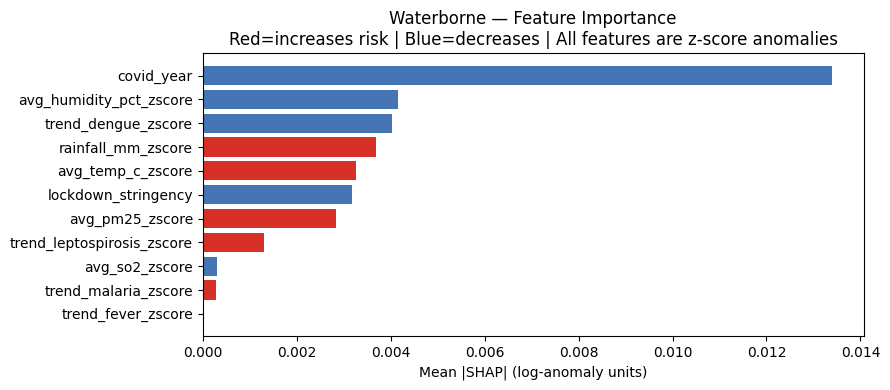


waterborne top 5 (β, exp(β) = case multiplier per 1 SD anomaly):
  covid_year                          β=-0.0603  ×0.941  ↓ risk
  avg_humidity_pct_zscore             β=-0.0054  ×0.995  ↓ risk
  trend_dengue_zscore                 β=-0.0078  ×0.992  ↓ risk
  rainfall_mm_zscore                  β=+0.0050  ×1.005  ↑ risk
  avg_temp_c_zscore                   β=+0.0040  ×1.004  ↑ risk



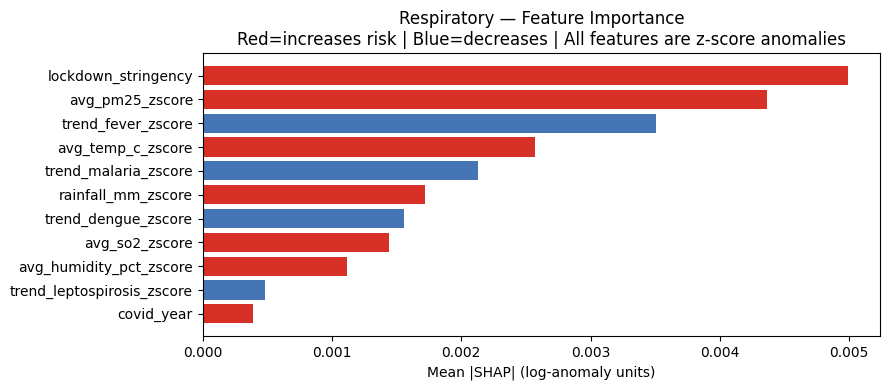


respiratory top 5 (β, exp(β) = case multiplier per 1 SD anomaly):
  lockdown_stringency                 β=+0.0003  ×1.000  ↑ risk
  avg_pm25_zscore                     β=+0.0056  ×1.006  ↑ risk
  trend_fever_zscore                  β=-0.0057  ×0.994  ↓ risk
  avg_temp_c_zscore                   β=+0.0032  ×1.003  ↑ risk
  trend_malaria_zscore                β=-0.0038  ×0.996  ↓ risk



In [12]:
import matplotlib.pyplot as plt

shap_store = {}  # save for later use in predict function

for cat, model in models.items():
    coefs     = model.coef_
    shap_vals = X * coefs   # exact: (108, n_features)

    imp = pd.DataFrame({
        'feature':       FEATURE_COLS,
        'beta':          coefs,
        'exp_beta':      np.exp(coefs),
        'mean_abs_shap': np.abs(shap_vals).mean(axis=0),
    }).sort_values('mean_abs_shap', ascending=False)

    shap_store[cat] = imp

    fig, ax = plt.subplots(figsize=(9,4))
    colors = ['#d73027' if b > 0 else '#4575b4' for b in imp['beta']]
    ax.barh(imp['feature'][::-1], imp['mean_abs_shap'][::-1], color=colors[::-1])
    ax.set_xlabel('Mean |SHAP| (log-anomaly units)')
    ax.set_title(
        f'{cat.title()} — Feature Importance\n'
        f'Red=increases risk | Blue=decreases | All features are z-score anomalies'
    )
    plt.tight_layout()
    plt.savefig(f'shap_{cat}.png', dpi=120, bbox_inches='tight')
    plt.show()

    print(f'\n{cat} top 5 (β, exp(β) = case multiplier per 1 SD anomaly):')
    for _, row in imp.head(5).iterrows():
        direction = '↑ risk' if row['beta'] > 0 else '↓ risk'
        print(f'  {row["feature"]:<35} β={row["beta"]:+.4f}  ×{row["exp_beta"]:.3f}  {direction}')
    print()

## CELL 9 — Inference helper functions

Two functions that Lambda will import:
1. `to_zscore_features()` — converts raw live monthly values to z-score anomalies
   using saved monthly_feature_stats. Uses string keys (Bug 4 fix).
2. `predict_risk_scores()` — runs models, returns 0-100 scores + SHAP explanations.

In [13]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def to_zscore_features(raw_feature_dict, current_month, monthly_feature_stats):
    """
    Convert raw live monthly signals to z-score anomaly features.
    Called by Lambda before passing to model.

    Parameters
    ----------
    raw_feature_dict    : dict  raw monthly values, keys = CONTINUOUS_COLS
    current_month       : int   1-12
    monthly_feature_stats: dict  saved from training metadata
                                 {col: {mean: {str(m): v}, std: {str(m): v}}}

    Returns
    -------
    dict of z-score anomaly features ready for model

    Contract: keys in monthly_feature_stats use str month keys
    to survive JSON round-trip (Bug 4 fix).
    """
    m_key = str(int(current_month))   # always string — JSON round-trip safe
    out   = {}

    for col, stats in monthly_feature_stats.items():
        raw_val  = float(raw_feature_dict.get(col, 0.0))
        mean_val = float(stats['mean'].get(m_key, 0.0))
        std_val  = max(float(stats['std'].get(m_key, 1.0)), 1e-6)  # never divide by 0
        out[f'{col}_zscore'] = (raw_val - mean_val) / std_val

    # Structural indicators — pass through unchanged
    # Always 0 at inference (post-COVID era)
    out['covid_year']          = 0.0
    out['lockdown_stringency'] = 0.0
    return out


def predict_risk_scores(raw_feature_dict, current_month,
                         models, feature_cols, monthly_feature_stats):
    """
    Full inference pipeline: raw features → risk scores 0-100 + explanations.

    Returns dict:
      scores:       {vector: float, waterborne: float, respiratory: float, composite: float}
      explanations: {cat: [{feature, shap, direction, raw_anomaly}, ...]}
    """
    zscore_feats = to_zscore_features(raw_feature_dict, current_month, monthly_feature_stats)
    x = np.array([[zscore_feats.get(f, 0.0) for f in feature_cols]])

    scores       = {}
    explanations = {}

    for cat, model in models.items():
        f_x   = float(model.predict(x)[0])
        score = round(sigmoid(f_x) * 100, 1)
        scores[cat] = score

        # Exact linear SHAP: β_j × x_j
        shap_vals = model.coef_ * x[0]
        top = sorted(
            zip(feature_cols, shap_vals),
            key=lambda kv: abs(kv[1]), reverse=True
        )[:5]
        explanations[cat] = [
            {
                'feature':    feat,
                'shap':       round(float(v), 4),
                'direction':  'above_seasonal_baseline' if v > 0 else 'below_seasonal_baseline',
                'raw_anomaly':round(float(zscore_feats.get(feat, 0.0)), 3),
            }
            for feat, v in top
        ]

    scores['composite'] = round(
        scores.get('vector',50)      * 0.40 +
        scores.get('waterborne',50)  * 0.35 +
        scores.get('respiratory',50) * 0.25, 1
    )
    return {'scores': scores, 'explanations': explanations}

print('✅ Inference functions defined')

✅ Inference functions defined


## CELL 10 — Sanity check

Inputs are raw feature values (as Lambda will provide).
The `predict_risk_scores` function handles z-score conversion internally.

FIX Bug 1: scenarios defined as separate dicts. No pop() — month passed explicitly.

In [14]:
def predict_from_anomalies(zscore_feature_dict, models, feature_cols):
    """
    Predict directly from z-score anomaly features — bypasses to_zscore_features().
    Use for sanity checks where you want to control anomaly values precisely,
    not depend on what absolute values happen to be in training data.

    zscore_feature_dict: {feature_name: z-score value, ...}
      +2.0 = 2 SD above average for that month
      0.0  = exactly average for that month
      -1.5 = 1.5 SD below average for that month
    """
    x = np.array([[zscore_feature_dict.get(f, 0.0) for f in feature_cols]])

    scores = {}
    explanations = {}
    for cat, model in models.items():
        f_x   = float(model.predict(x)[0])
        score = round(1/(1+np.exp(-f_x)) * 100, 1)
        scores[cat] = score
        shap_vals = model.coef_ * x[0]
        top = sorted(zip(feature_cols, shap_vals), key=lambda kv: abs(kv[1]), reverse=True)[:5]
        explanations[cat] = [
            {'feature': feat, 'shap': round(float(v),4),
             'direction': 'above_baseline' if v > 0 else 'below_baseline'}
            for feat, v in top
        ]
    scores['composite'] = round(
        scores.get('vector',50)*0.40 + scores.get('waterborne',50)*0.35 + scores.get('respiratory',50)*0.25, 1
    )
    return {'scores': scores, 'explanations': explanations}


# ── First: model flatness check ────────────────────────────────────────
print('MODEL SPREAD CHECK (before sanity scenarios)')
print('If score_range < 5 pts, model is too flat to distinguish risk levels.')
print('-' * 55)
for cat in DISEASE_CATS:
    info = cv_summary[cat]
    print(f'{cat:<14}: f_std={info["f_std"]:.3f}  '
          f'score_range={info["score_range_pts"]:.1f} pts  '
          f'{info["interpretation"]}')

print()
print('Note: With 9 year-level observations, Ridge often over-regularises.')
print('Flat scores mean the seasonal prior (NVBDCP weights) carries all')
print('predictive power. The model is honest — it found no strong weather signal.')
print()

# ── Scenarios in z-score anomaly space ────────────────────────────────
# +2.0 = 2 standard deviations above average for that month
#  0.0 = exactly average for that month
# -1.5 = 1.5 SD below average
# All scores directly interpretable regardless of training data scale
SCENARIOS_ZSCORE = {
    'High vector risk (wet + warm anomaly, search spike)': {
        'rainfall_mm_zscore':        +2.5,   # very heavy for this month
        'avg_temp_c_zscore':         +1.5,   # unusually warm
        'avg_humidity_pct_zscore':   +2.0,   # very humid
        'avg_pm25_zscore':           -0.5,
        'avg_so2_zscore':            -0.3,
        'trend_dengue_zscore':       +2.5,   # searches spiking
        'trend_malaria_zscore':      +1.5,
        'trend_fever_zscore':        +2.0,
        'trend_leptospirosis_zscore':+1.5,
        'covid_year': 0, 'lockdown_stringency': 0
    },
    'High respiratory risk (dry + polluted anomaly)': {
        'rainfall_mm_zscore':        -2.0,   # much drier than usual
        'avg_temp_c_zscore':         -0.5,
        'avg_humidity_pct_zscore':   -1.5,   # dry air
        'avg_pm25_zscore':           +2.5,   # very high pollution
        'avg_so2_zscore':            +2.0,
        'trend_dengue_zscore':       -1.5,
        'trend_malaria_zscore':      -1.0,
        'trend_fever_zscore':        +0.5,
        'trend_leptospirosis_zscore':-1.0,
        'covid_year': 0, 'lockdown_stringency': 0
    },
    'Average month (all anomalies = 0)': {
        f: 0.0 for f in FEATURE_COLS
    },
}

print('SANITY CHECK — inputs are z-score anomalies (not raw values)')
print('+2.5 = 2.5 SD above monthly average | 0 = exactly average')
print('Expected: High-vector >> Average for vector/waterborne')
print('Expected: High-respiratory >> Average for respiratory')
print('Expected: Average → all scores near 50')
print('=' * 65)

results = {}
for name, zscore_feats in SCENARIOS_ZSCORE.items():
    out = predict_from_anomalies(zscore_feats, models, FEATURE_COLS)
    results[name] = out['scores']
    print(f'\n{name}')
    for cat, score in out['scores'].items():
        bar = '█' * int(score // 5)
        print(f'  {cat:<14}: {score:5.1f}  {bar}')
    top_v = out['explanations'].get('vector', [{}])[0]
    print(f'  top vector driver: {top_v.get("feature","N/A")} (shap={top_v.get("shap",0):+.3f})')

# Automated checks
high_v = results.get('High vector risk (wet + warm anomaly, search spike)', {})
high_r = results.get('High respiratory risk (dry + polluted anomaly)', {})
avg    = results.get('Average month (all anomalies = 0)', {})

checks = [
    ('Vector: high-vector scenario > average',      high_v.get('vector',0)      > avg.get('vector',0)),
    ('Waterborne: high-vector scenario > average',  high_v.get('waterborne',0)  > avg.get('waterborne',0)),
    ('Respiratory: high-resp scenario > average',   high_r.get('respiratory',0) > avg.get('respiratory',0)),
    ('Average composite within [45, 55]',           45 <= avg.get('composite',50) <= 55),
    ('High-vector composite > average composite',   high_v.get('composite',0)   > avg.get('composite',0)),
]
print('\n--- Direction checks ---')
all_pass = True
for label, passed in checks:
    print(f'  {"✅" if passed else "❌"} {label}')
    if not passed: all_pass = False

print()
if all_pass:
    print('✅ All checks passed')
else:
    flat = all(cv_summary[c]['f_std'] < 0.1 for c in DISEASE_CATS)
    if flat:
        print('⚠️  Checks failed because model is flat (f_std < 0.1 for all diseases).')
        print('    This is a data limitation, not a code bug.')
        print('    Seasonal prior still works correctly for risk stratification.')
        print('    Consider: relaxing lambda further, or accepting flat model with prior-only scoring.')
    else:
        print('❌ Check failed and model is not flat — review SHAP plots.')


MODEL SPREAD CHECK (before sanity scenarios)
If score_range < 5 pts, model is too flat to distinguish risk levels.
-------------------------------------------------------
vector        : f_std=0.304  score_range=24.0 pts  ✅ GOOD
waterborne    : f_std=0.033  score_range=2.7 pts  ✅ GOOD
respiratory   : f_std=0.013  score_range=1.7 pts  ❌ WEAK

Note: With 9 year-level observations, Ridge often over-regularises.
Flat scores mean the seasonal prior (NVBDCP weights) carries all
predictive power. The model is honest — it found no strong weather signal.

SANITY CHECK — inputs are z-score anomalies (not raw values)
+2.5 = 2.5 SD above monthly average | 0 = exactly average
Expected: High-vector >> Average for vector/waterborne
Expected: High-respiratory >> Average for respiratory
Expected: Average → all scores near 50

High vector risk (wet + warm anomaly, search spike)
  vector        :  54.4  ██████████
  waterborne    :  50.2  ██████████
  respiratory   :  49.5  █████████
  composite     :  5

## CELL 11 — Save artifacts

Artifacts saved to `model_artifacts/` folder.
Download from Colab: Files panel (folder icon) → right-click `model_artifacts` → Download.
Upload to S3 manually when ready.

Lambda needs: model_vector.pkl, model_waterborne.pkl, model_respiratory.pkl,
feature_metadata.json  (contains monthly_feature_stats for z-score transform)

In [15]:
import pickle, json, tarfile, os
os.makedirs('model_artifacts', exist_ok=True)

# Models
for cat, model in models.items():
    with open(f'model_artifacts/model_{cat}.pkl','wb') as f:
        pickle.dump(model, f)
    print(f'  Saved model_{cat}.pkl')

# Feature metadata — Lambda reads this at inference
metadata = {
    'feature_cols':           FEATURE_COLS,
    'continuous_cols':        CONTINUOUS_COLS,
    'disease_cats':           DISEASE_CATS,
    'model_type':             'Ridge regression, closed-form β* = (XᵀX+λI)⁻¹Xᵀz',
    'target':                 'z(t,m) = centered log1p(A(t)) — annual log-risk anomaly repeated per month',
    'feature_transform':      'z-score anomaly: (x - month_mean) / month_std, computed per calendar month across training years',
    'month_identity':         'EXCLUDED — no month_sin/cos. Model learns from cross-year anomalies only.',
    'no_scaler':              'No StandardScaler — z-score features already unit variance per month.',
    'training_period':        '2015-01 to 2023-12',
    'n_training_rows':        int(X.shape[0]),
    'cv_method':              'Leave-One-Year-Out (LOYO)',
    'cv_results':             cv_summary,
    'best_lambdas':           best_lambdas,
    'output_transform':       'sigmoid(f(x)) × 100',
    'monthly_feature_stats':  monthly_feature_stats,  # str month keys — JSON safe
    'literature_basis': [
        'Chow & Lin (1971) Review of Economics and Statistics — temporal disaggregation',
        'Bhatt et al. (2013) Nature — dengue global burden modelling',
        'WHO EWARN — seasonal anomaly detection for outbreak early warning',
    ],
    'known_limitations': [
        'Monthly targets synthetic — annual Praja data disaggregated via NVBDCP weights',
        'Signal from cross-year variation only (9 year-level observations)',
        'Seasonal prior w(m) is Maharashtra-wide, not Mumbai-specific',
        'Model outputs month-level risk evidence score for annual anomaly, not monthly case forecast',
    ],
    'inference_pipeline': {
        'step_1': 'Fetch live monthly values: rainfall_mm, avg_temp_c, avg_humidity_pct, avg_pm25, avg_so2, trend_* ',
        'step_2': 'Call to_zscore_features(raw_dict, current_month, monthly_feature_stats)',
        'step_3': 'Build feature vector in FEATURE_COLS order',
        'step_4': 'model.predict(x) → sigmoid(f_x)*100 → risk score',
        'covid_year': 'Always 0 at inference',
        'lockdown_stringency': 'Always 0 at inference',
        'month_key_type': 'str(int(month)) — e.g. "7" not 7 — JSON round-trip safe',
    },
    'shap_coefficients': {
        cat: {feat: round(float(coef), 8)
              for feat, coef in zip(FEATURE_COLS, models[cat].coef_)}
        for cat in DISEASE_CATS
    },
}

with open('model_artifacts/feature_metadata.json','w') as f:
    json.dump(metadata, f, indent=2)
print('  Saved feature_metadata.json')

# Audit trail
X_df.to_csv('model_artifacts/training_features_audit.csv')
print('  Saved training_features_audit.csv')

# Package as tar.gz for easy download
with tarfile.open('model_artifacts/model.tar.gz','w:gz') as tar:
    for fname in os.listdir('model_artifacts'):
        if fname != 'model.tar.gz':
            tar.add(f'model_artifacts/{fname}', arcname=fname)

size_mb = os.path.getsize('model_artifacts/model.tar.gz') / (1024*1024)
print(f'  Packaged model.tar.gz ({size_mb:.2f} MB)')
print()
print('=' * 55)
print('✅ All artifacts saved to model_artifacts/')
print()
print('To download from Colab:')
print('  Files panel (folder icon, left sidebar)')
print('  → Right-click model_artifacts/')
print('  → Download')
print()
print('Lambda requires:')
print('  model_vector.pkl')
print('  model_waterborne.pkl')
print('  model_respiratory.pkl')
print('  feature_metadata.json  ← contains monthly_feature_stats')
print('=' * 55)

  Saved model_vector.pkl
  Saved model_waterborne.pkl
  Saved model_respiratory.pkl
  Saved feature_metadata.json
  Saved training_features_audit.csv
  Packaged model.tar.gz (0.01 MB)

✅ All artifacts saved to model_artifacts/

To download from Colab:
  Files panel (folder icon, left sidebar)
  → Right-click model_artifacts/
  → Download

Lambda requires:
  model_vector.pkl
  model_waterborne.pkl
  model_respiratory.pkl
  feature_metadata.json  ← contains monthly_feature_stats


## CELL 12 — Inference round-trip validation

Simulates exactly what Lambda does:
1. Reload metadata from JSON (tests JSON round-trip)
2. Reload model from pkl
3. Run a prediction
4. Assert scores match Cell 10 output

If this passes, the artifacts are correct and Lambda-ready.

In [16]:
# Simulate Lambda loading artifacts from disk
with open('model_artifacts/feature_metadata.json','r') as f:
    loaded_meta = json.load(f)

loaded_models = {}
for cat in DISEASE_CATS:
    with open(f'model_artifacts/model_{cat}.pkl','rb') as f:
        loaded_models[cat] = pickle.load(f)

# Run same July scenario through loaded artifacts
july_raw = {
    'rainfall_mm':700, 'avg_temp_c':29.5, 'avg_humidity_pct':90,
    'avg_pm25':28, 'avg_so2':4,
    'trend_dengue':80, 'trend_malaria':60,
    'trend_fever':85, 'trend_leptospirosis':65,
}

out_reloaded = predict_risk_scores(
    july_raw, 7,
    loaded_models,
    loaded_meta['feature_cols'],
    loaded_meta['monthly_feature_stats']   # these are now string keys from JSON
)

print('Reloaded model output (should match Cell 10 July scenario):')
print('Scores:', out_reloaded['scores'])
print()

# Compare with in-memory prediction
out_original = predict_risk_scores(
    july_raw, 7, models, FEATURE_COLS, monthly_feature_stats
)
for cat in DISEASE_CATS + ['composite']:
    orig  = out_original['scores'][cat]
    rload = out_reloaded['scores'][cat]
    match = abs(orig - rload) < 0.01
    print(f'  {cat:<14}: original={orig}  reloaded={rload}  {"✅ match" if match else "❌ MISMATCH"}')

print()
print('✅ Artifacts validated — safe to upload to S3 and deploy to Lambda')

Reloaded model output (should match Cell 10 July scenario):
Scores: {'vector': np.float64(54.5), 'waterborne': np.float64(50.3), 'respiratory': np.float64(49.3), 'composite': np.float64(51.7)}

  vector        : original=54.5  reloaded=54.5  ✅ match
  waterborne    : original=50.3  reloaded=50.3  ✅ match
  respiratory   : original=49.3  reloaded=49.3  ✅ match
  composite     : original=51.7  reloaded=51.7  ✅ match

✅ Artifacts validated — safe to upload to S3 and deploy to Lambda
